# LIBRARIES

In [1]:
import numpy as np, pandas as pd, time, matplotlib.pyplot as plt, os
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Conv1D, MaxPooling1D, Flatten, SimpleRNN, GRU, RNN, Bidirectional, TimeDistributed
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, MaxAbsScaler
from scipy.stats import pearsonr
from tensorflow.keras.layers import GRU, Conv1D, BatchNormalization, Input, LeakyReLU, ReLU
from keras.optimizers import Adam, RMSprop

# DATA

Training data has 7 features: Open, High, Low, Close, Volume, Count, VWAP for past 500k (time steps?) observations

In [2]:
tXY = pd.read_csv('tXY.csv', index_col='id')

In [10]:
pY = pd.read_csv('sampleSubmission.csv', index_col='id')


# PRE PROCESSING & FEATURE ENGINEERING

## HELPER FUNCTIONS

In [3]:
def log_return(series, periods=1):
    return np.log(series).diff(periods=periods)
def upper_shadow(df):
    return df['High'] - np.maximum(df['Close'], df["Open"])
def lower_shadow(df):
    return np.minimum(df['Close'], df['Open']) - df['Low']

In [4]:
def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

In [5]:
# https://stackoverflow.com/a/46620771
from keras import backend as K
def correlation_coefficient_loss(y_true, y_pred):
    x = y_true
    y = y_pred
    mx = K.mean(x)
    my = K.mean(y)
    xm, ym = x-mx, y-my
    r_num = K.sum(tf.multiply(xm,ym))
    r_den = K.sqrt(tf.multiply(K.sum(K.square(xm)), K.sum(K.square(ym))))
    r = r_num / r_den

    r = K.maximum(K.minimum(r, 1.0), -1.0)
    return 1 - K.square(r)

## COLUMN TRANSFORMATIONS

In [6]:
tXY["trade_size"] = tXY["Volume"] / tXY["Count"]
tXY["5_min_return"] = log_return(tXY["VWAP"], periods=5)
tXY["log_close"] = np.log(tXY["Close"])
tXY["lower_shadow"] = lower_shadow(tXY)
tXY["upper_shadow"] = upper_shadow(tXY)
tXY.fillna(0, inplace=True)

In [7]:
TEST_MODE = False

## SCALING AND DROPPING COLUMNS

In [8]:
scaler = MinMaxScaler()
cols = ["Count", "Open", "High", "Low", "log_close", "Volume", "VWAP", "5_min_return", "trade_size", "upper_shadow", "lower_shadow"]
tXYs = pd.DataFrame(scaler.fit_transform(tXY[cols]), index=tXY.index, columns=cols)
scalerY = MinMaxScaler()
tXYs["Close"] = scalerY.fit_transform(tXY["Close"].values.reshape(-1, 1))
tXYs = tXYs.drop(["VWAP", "Volume"], axis=1)

# SELECTING DATA

# WINDOW PARAMETERS

taX.shape=(K,Nx,p)=(640, 40000, 10); taY=(K,Ny)=(640, 24431)


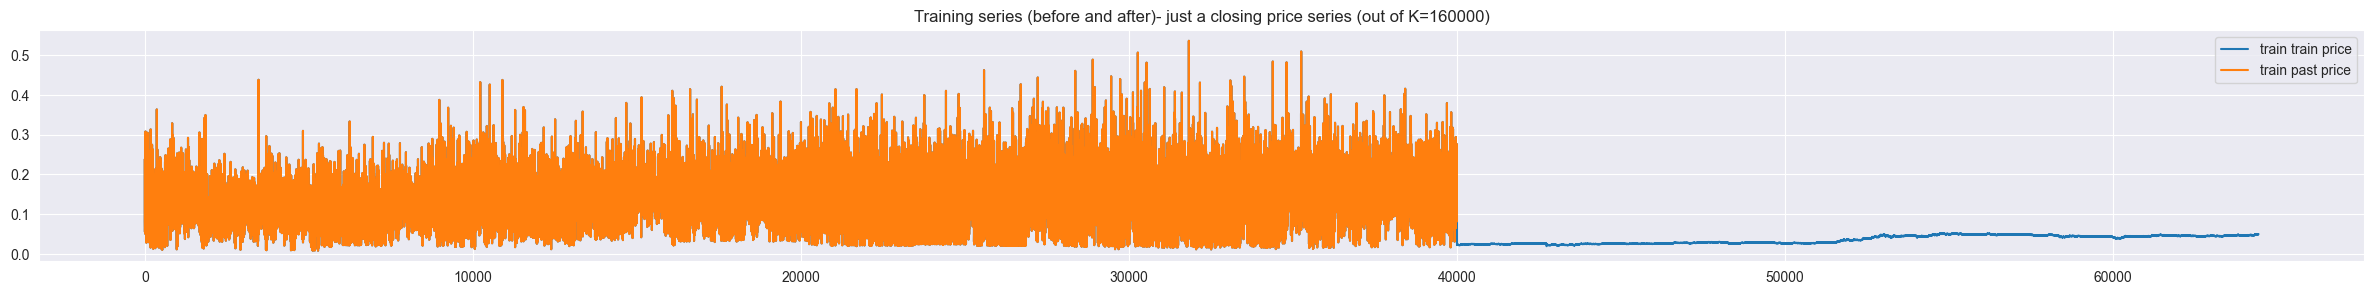

In [11]:
K, (N, p), Nx, Ny = 160000, tXYs.shape, 40000, len(pY)  # samples, dataset dim, train set size, forecast set size

test_offset = Ny if TEST_MODE else 0

LtX, LtY = [], []
for i in range(N-Ny-K-test_offset, N-Ny-test_offset, 250):      # sliding window of 500   # populate K samples with past X series and future Y series

  LtX.append(tXYs.iloc[(i-Nx):i, :].values)        # X: historical 7Dim observations for Nx steps behind
  LtY.append(tXYs.loc[i:(i+Ny-1),'Close'].values)  # Y: future closing prices for Ny steps ahead
taX, taY = np.array(LtX), np.array(LtY)           # training arrays past input X and future output Y
print(f'taX.shape=(K,Nx,p)={taX.shape}; taY=(K,Ny)={taY.shape}')  # convert to 3-tensors

df = pd.DataFrame(np.r_[taX[0,:,6], taY[0,:]], columns=['train train price'])
ax = df.plot(figsize=(30,3), title=f'Training series (before and after)- just a closing price series (out of K={K})');
pd.DataFrame(taX[0,:,6], columns=['train past price']).plot(grid=True, ax=ax);

### Sanity Check

In [12]:
print(taX.shape)
print(taY[0,:].shape)
print(taX[0,:,3].shape)
print(p)

(640, 40000, 10)
(24431,)
(40000,)
10


# OPTIMIZATION

# BASE MODEL

In [14]:
%%time
tf.random.set_seed(0)   # always seed your experiments
Init = keras.initializers.GlorotNormal(seed=0) # seed all that you can

model = keras.models.Sequential()
model.add(keras.layers.Input(shape=[None, p]))
model.add(Bidirectional(LSTM(units=32, return_sequences=True)))

for rate in (1, 2, 4, 8) * 2:
    model.add(Conv1D(filters=20, kernel_size=2, padding="causal",
                                  activation="relu", dilation_rate=rate))
model.add(Conv1D(filters=10, kernel_size=1))
model.add(Dropout(0.2))
model.add(GRU(5, kernel_initializer=Init, recurrent_initializer=Init))
model.add(Dense(Ny, kernel_initializer=Init))
model.summary()
model.compile(loss="mse", optimizer='adam', metrics=[last_time_step_mse])
history = model.fit(taX, taY, epochs=20, batch_size=32, validation_split=0.2)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_1 (Bidirecti  (None, None, 64)          11008     
 onal)                                                           
                                                                 
 conv1d_9 (Conv1D)           (None, None, 20)          2580      
                                                                 
 conv1d_10 (Conv1D)          (None, None, 20)          820       
                                                                 
 conv1d_11 (Conv1D)          (None, None, 20)          820       
                                                                 
 conv1d_12 (Conv1D)          (None, None, 20)          820       
                                                                 
 conv1d_13 (Conv1D)          (None, None, 20)          820       
                                                      

2024-04-14 13:09:59.429795: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-14 13:09:59.761777: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-14 13:09:59.768405: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-14 13:10:03.572789: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-14 13:10:04.748173: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-14 13:10:07.109145: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-14 13:10:09.641708: I tensorflow/core/grappler/optimizers/cust

16/16 [==============================] - ETA: 0s - loss: 0.0192 - last_time_step_mse: 0.0427

2024-04-14 13:12:36.536705: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-14 13:12:36.646772: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-14 13:12:36.647038: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-14 13:12:39.326108: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


16/16 [==============================] - 170s 10s/step - loss: 0.0192 - last_time_step_mse: 0.0427 - val_loss: 0.2894 - val_last_time_step_mse: 0.3876
Epoch 2/20
16/16 [==============================] - 147s 9s/step - loss: 0.0146 - last_time_step_mse: 0.0386 - val_loss: 0.2326 - val_last_time_step_mse: 0.3459
Epoch 3/20
16/16 [==============================] - 141s 9s/step - loss: 0.0097 - last_time_step_mse: 0.0269 - val_loss: 0.1832 - val_last_time_step_mse: 0.2426
Epoch 4/20
16/16 [==============================] - 138s 9s/step - loss: 0.0093 - last_time_step_mse: 0.0227 - val_loss: 0.2018 - val_last_time_step_mse: 0.2268
Epoch 5/20
16/16 [==============================] - 135s 8s/step - loss: 0.0091 - last_time_step_mse: 0.0226 - val_loss: 0.2010 - val_last_time_step_mse: 0.2308
Epoch 6/20
16/16 [==============================] - 138s 9s/step - loss: 0.0091 - last_time_step_mse: 0.0226 - val_loss: 0.2000 - val_last_time_step_mse: 0.2379
Epoch 7/20
16/16 [==========================

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Discarded (victim of GPU error/recovery) (00000005:kIOGPUCommandBufferCallbackErrorInnocentVictim)
	<AGXG13GFamilyCommandBuffer: 0x475352f80>
    label = <none> 
    device = <AGXG13GDevice: 0x302bb3c00>
        name = Apple M1 
    commandQueue = <AGXG13GFamilyCommandQueue: 0x318019000>
        label = <none> 
        device = <AGXG13GDevice: 0x302bb3c00>
            name = Apple M1 
    retainedReferences = 1


16/16 [==============================] - 162s 10s/step - loss: 0.0017 - last_time_step_mse: 0.0053 - val_loss: 0.0598 - val_last_time_step_mse: 0.0323
Epoch 14/20
16/16 [==============================] - 174s 11s/step - loss: 0.0014 - last_time_step_mse: 0.0042 - val_loss: 0.0565 - val_last_time_step_mse: 0.0259
Epoch 15/20
16/16 [==============================] - 168s 11s/step - loss: 0.0014 - last_time_step_mse: 0.0043 - val_loss: 0.0545 - val_last_time_step_mse: 0.0220
Epoch 16/20
16/16 [==============================] - 164s 10s/step - loss: 0.0013 - last_time_step_mse: 0.0039 - val_loss: 0.0540 - val_last_time_step_mse: 0.0195
Epoch 17/20
16/16 [==============================] - 159s 10s/step - loss: 0.0013 - last_time_step_mse: 0.0040 - val_loss: 0.0535 - val_last_time_step_mse: 0.0179
Epoch 18/20
16/16 [==============================] - 158s 10s/step - loss: 0.0012 - last_time_step_mse: 0.0039 - val_loss: 0.0533 - val_last_time_step_mse: 0.0169
Epoch 19/20
16/16 [===============

## WAVENET

In [75]:
# %%time
# tf.random.set_seed(0)   # always seed your experiments
# Init = tf.keras.initializers.GlorotUniform(seed=0) # seed all that you can
# 
# 
# model = Sequential()
# model.add(Input(shape=[None, p]))
# 
# #model.add(Bidirectional(LSTM(units=32, return_sequences=True)))
# 
# for rate in (1, 2, 4, 8) * 2:
#     model.add(Conv1D(filters=32, kernel_size=4, padding="causal", activation="relu", dilation_rate=rate))
#                                   
# model.add(Conv1D(filters=16, kernel_size=2))
# model.add(Dropout(0.2))
# 
# model.add(GRU(8, kernel_initializer=Init, recurrent_initializer=Init))
# model.add(Dense(Ny, kernel_initializer=Init))
# 
# model.summary()
# model.compile(loss="mse", optimizer='adam',metrics=[last_time_step_mse])
# 
# 


In [76]:
#history = model.fit(taX, taY, epochs=20, validation_split=0.2)

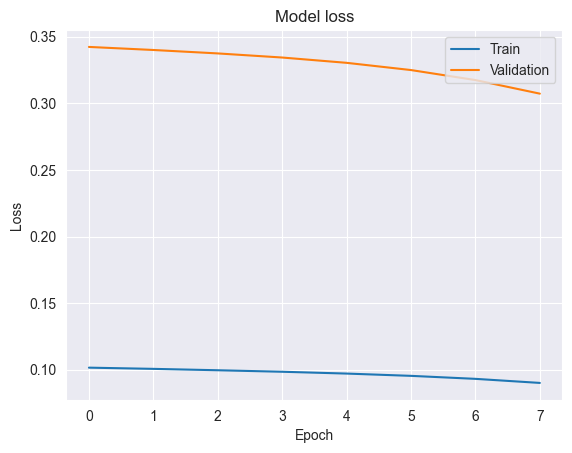

In [15]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.savefig('bidirectional_exp-1')
plt.show()

2024-04-13 19:05:39.795559: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-13 19:05:39.972070: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-13 19:05:39.985265: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-13 19:05:41.143121: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 3s 3s/step
Correlation coefficient: 0.12


/var/folders/9g/y_c7n71j1h7_qfrssnpsr4pc0000gn/T/ipykernel_1650/3036492027.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tX_recent['Close'] = scalerY.inverse_transform(tX_recent['Close'].values.reshape(-1, 1))


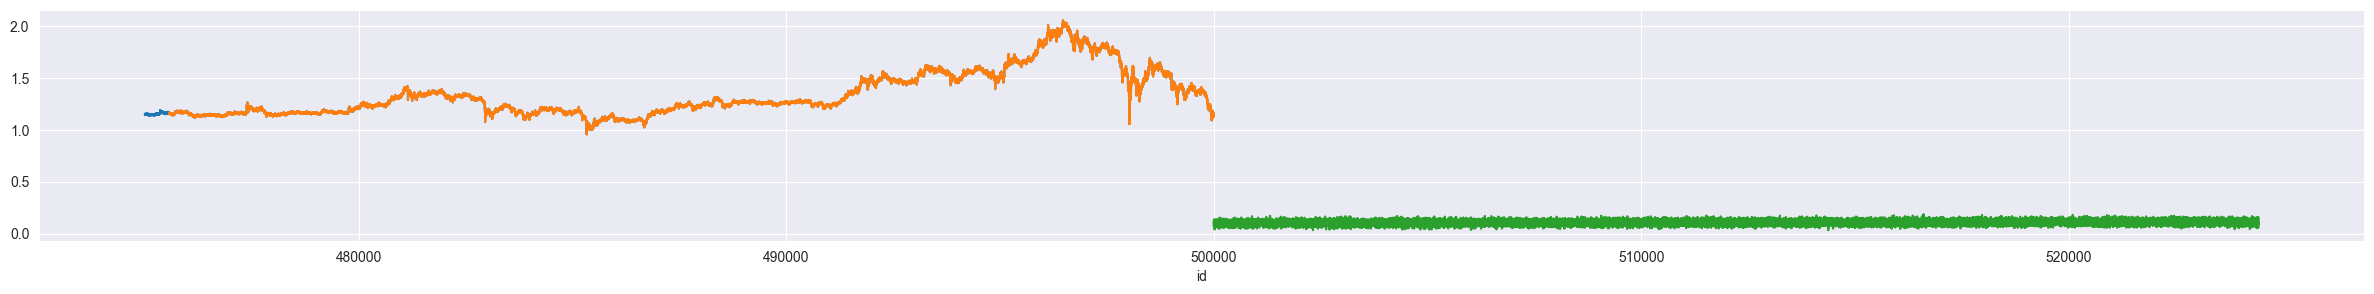

In [16]:
tX_recent = tXYs.iloc[N-Ny-Ny:-Ny,:] if TEST_MODE else tXYs.iloc[-Nx:,:]  # most recent history of the coin

y_pred = model.predict(tX_recent.values[np.newaxis,...]).flatten()  # the model expects a 3-tensor (K=1,Nx,p)
pY['Close'] = scalerY.inverse_transform(y_pred.reshape(-1, 1))
tX_recent['Close'] = scalerY.inverse_transform(tX_recent['Close'].values.reshape(-1, 1))

tX_recent.Close.plot(figsize=(30,3), grid=True)
tXY.loc[N-Ny:N-1,'Close'].plot(grid=True)
pY.Close.plot(grid=True)
ax.legend(["Future predicted closing prices", "Historical (train) closing prices"])

pearsonr(y_pred, tXY.loc[N-Ny:N-1,'Close'].values) # Correlation coefficient metric
print(f'Correlation coefficient: {pearsonr(y_pred, tXY.loc[N-Ny:N-1,"Close"].values)[0]:.2f}')

# PREDICTIONS

In [ ]:
ToCSV = lambda df, fname: df.round(2).to_csv(f'{fname}.csv', index_label='id') # rounds values to 2 decimals
ToCSV(pY, '📈bidirectional_exp-1🐍')
